## Overview
This notebook contains the set up and modeling of our Music Recommendation Algorithm.



#Set up

## Full Subset (10,000 songs) (~10 min)
This is the download, extraction, and embedding of the primary features of the  dataset.

**The faster alternate dataset is below**

First step is to download the dataset. I am going to download a subset from [here](http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz)

In [ ]:
# Timing full set up
import time
start = time.time()

In [ ]:
# get subset
# ~4 min download
# ~1.8 GB
!wget "http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz"
# Unzip dataset
!tar -xf "millionsongsubset.tar.gz"

--2023-05-10 02:18:26--  http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz
Resolving labrosa.ee.columbia.edu (labrosa.ee.columbia.edu)... 128.59.66.11
Connecting to labrosa.ee.columbia.edu (labrosa.ee.columbia.edu)|128.59.66.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1981914968 (1.8G) [application/x-gzip]
Saving to: ‘millionsongsubset.tar.gz.2’

millionsongsubset.t 100%[===================>]   1.85G  11.2MB/s    in 2m 49s  

2023-05-10 02:21:15 (11.2 MB/s) - ‘millionsongsubset.tar.gz.2’ saved [1981914968/1981914968]



Second step is to get the python wrapper scripts from the million songs [github](https://github.com/tbertinmahieux/MSongsDB)

In [ ]:
!git clone "https://github.com/tbertinmahieux/MSongsDB.git"
import os
import sys
msd_subset_path='/content/MillionSongSubset/'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
msd_code_path='/content/MSongsDB/'
sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

Cloning into 'MSongsDB'...
remote: Enumerating objects: 3118, done.
remote: Total 3118 (delta 0), reused 0 (delta 0), pack-reused 3118
Receiving objects: 100% (3118/3118), 30.11 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (2044/2044), done.


In [ ]:
import hdf5_getters as GETTERS # From MSongsDB github PythonSrc -> ignore linter warning, appending it to path doesn't update linter
import os
import pathlib
import numpy as np
import pandas as pd
import tables
import re

# Helper functions
def open_h5_file_read(h5filename):
    return tables.open_file(f, mode='r')

def get_id(h5):
    return GETTERS.get_song_id(h5)

def get_song_title(h5):
    return GETTERS.get_title(h5)

def get_artist_name(h5):
    return GETTERS.get_artist_name(h5)

def get_timbre(h5):
    return GETTERS.get_segments_timbre(h5).mean(axis=0)

def get_chromas(h5):
    return GETTERS.get_segments_pitches(h5).mean(axis=0)

def get_duration(h5):
    return GETTERS.get_duration(h5)

def get_tempo(h5):
    return GETTERS.get_tempo(h5)

def get_time_signature(h5):
    return GETTERS.get_time_signature(h5)

def get_loudness(h5):
    return GETTERS.get_loudness(h5)

def get_segmented_loudness_avg(h5):
    return GETTERS.get_segments_loudness_max(h5).mean()

def strip_quotes(song_str:str):
    strip_str =  re.sub("^b'|^b\"", "", song_str)
    strip_str = re.sub("'$|\"$", "", strip_str)
    return strip_str

def read_h5_values(song_dict:dict, file_path:os.PathLike, i:int):
    h5 = tables.open_file(file_path, mode='r')
    song_dict['song_id'][i] = get_id(h5)
    song_dict['song_title'][i] = get_song_title(h5)
    song_dict['artist_name'][i] = get_artist_name(h5)
    song_dict['duration'][i] = get_duration(h5)
    song_dict['tempo'][i] = get_tempo(h5)
    song_dict['time_signature'][i] = get_time_signature(h5)
    song_dict['timbre'][i] = get_timbre(h5)
    song_dict['chromas'][i] = get_chromas(h5)
    song_dict['segment_loudness_avg'][i] = get_segmented_loudness_avg(h5)
    song_dict['loudness'][i] = get_loudness(h5)
    h5.close()

In [ ]:
pl = pathlib.Path(msd_subset_path)
files = list(pl.rglob("*.h5"))

In [ ]:
file_amount = 10_000

In [ ]:
i = 0
song_dict = {'song_id': ['' for _ in range(file_amount)],
             'song_title': ['' for _ in range(file_amount)],
             'artist_name': ['' for _ in range(file_amount)],
             'duration': [0.0 for _ in range(file_amount)],
             'tempo': [0.0 for _ in range(file_amount)],
             'time_signature': [0 for _ in range(file_amount)],
             'timbre': [np.zeros((12,)) for _ in range(file_amount)],
             'chromas': [np.zeros((12,)) for _ in range(file_amount)],
             'segment_loudness_avg': [0.0 for _ in range(file_amount)],
             'loudness': [0.0 for _ in range(file_amount)],
            }

for f in files[:file_amount]:
    print(f'\r{i}', end='')
    h5 = tables.open_file(f, mode='r')
    song_dict['song_id'][i] = get_id(h5)
    song_dict['song_title'][i] = get_song_title(h5)
    song_dict['artist_name'][i] = get_artist_name(h5)
    song_dict['duration'][i] = get_duration(h5)
    song_dict['tempo'][i] = get_tempo(h5)
    song_dict['time_signature'][i] = get_time_signature(h5)
    song_dict['timbre'][i] = get_timbre(h5)
    song_dict['chromas'][i] = get_chromas(h5)
    song_dict['segment_loudness_avg'][i] = get_segmented_loudness_avg(h5)
    song_dict['loudness'][i] = get_loudness(h5)
    h5.close()
    i += 1

9999

In [ ]:
song_df = pd.DataFrame.from_dict(song_dict)

In [ ]:
song_df['song_title'] = song_df['song_title'].astype(str)
song_df['song_id'] = song_df['song_id'].astype(str)
song_df['artist_name'] = song_df['artist_name'].astype(str)

In [ ]:
song_df['song_title'] = song_df['song_title'].apply(strip_quotes)
song_df['song_id'] = song_df['song_id'].apply(strip_quotes)
song_df['artist_name'] = song_df['artist_name'].apply(strip_quotes)

In [ ]:
mfcc_cols = [f'MFCC{i}' for i in range(1,13)]
chroma_cols = [f'chroma{i}' for i in range(1,13)]

In [ ]:
song_df[mfcc_cols] = pd.DataFrame(song_df['timbre'].tolist(), index=song_df.index)
song_df[chroma_cols] = pd.DataFrame(song_df['chromas'].tolist(), index=song_df.index)

song_df.drop(columns=['timbre', 'chromas'], inplace=True)

In [ ]:
song_df

,song_id,song_title,artist_name,duration,tempo,time_signature,segment_loudness_avg,loudness,MFCC1,MFCC2,...,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12
0,SOAQIWX12A8C13C9AB,A Pretty Gal's Love,New Roanoke Jug Band,189.59628,96.064,1,-11.670540,-9.384,44.648927,-26.076131,...,0.710127,0.140242,0.220552,0.135399,0.253412,0.184307,0.201306,0.523881,0.197963,0.236648
1,SOHWDNK12A6D4F9837,Every Time I Look At You,Kiss,283.84608,149.012,4,-11.303423,-7.000,45.345974,38.307830,...,0.219740,0.452647,0.206628,0.282710,0.220724,0.263495,0.434178,0.181060,0.358220,0.224479
2,SODOQYK12A6D4F77FF,Looking Back,John Mayall & The Bluesbreakers,156.91710,120.736,4,-10.758087,-7.170,44.890605,9.726143,...,0.169748,0.402881,0.358817,0.510744,0.198387,0.161703,0.231886,0.192919,0.253971,0.248528
3,SONLOKJ12AB0187617,Think,The Rolling Stones,189.67465,132.903,1,-14.872094,-12.670,41.190751,16.153631,...,0.323026,0.553835,0.592734,0.362714,0.542790,0.307970,0.321415,0.293080,0.174338,0.283828
4,SODDUCR12A58A7756F,Rave On (Live 1982),Marshall Crenshaw,95.86893,162.653,4,-13.373701,-11.026,42.725882,-38.830825,...,0.280139,0.479506,0.150237,0.204195,0.111068,0.355038,0.576701,0.225805,0.347639,0.254396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,SOOWVUN12AB0185435,Zindegi,Chantal Chamandy,256.15628,84.960,4,-11.223550,-7.489,45.332947,-18.563458,...,0.340541,0.217260,0.243734,0.224076,0.333209,0.260623,0.228961,0.299203,0.338321,0.523974
9996,SOQEKJO12AB0188E78,La Mona Jacinta,Mar\xc3\xada Elena Walsh,150.09914,131.552,3,-15.483181,-12.517,40.520605,-43.884075,...,0.224752,0.190743,0.317449,0.256214,0.183961,0.422596,0.215548,0.277810,0.204479,0.222874
9997,SOEEPYY12A58A7B1C8,Le Precipice,Daara J,261.61587,91.005,4,-13.649032,-7.727,40.942089,-4.781163,...,0.241263,0.195128,0.337046,0.333763,0.276011,0.326179,0.350156,0.269583,0.279885,0.336661
9998,SOQUGNH12A6D4FBB0E,Overture (Genesis & Job),Don Francisco,311.22240,68.537,1,-22.709647,-16.294,34.561151,-6.668655,...,0.235766,0.116240,0.246805,0.147697,0.203432,0.518084,0.251020,0.339212,0.164435,0.184689


In [ ]:
end = time.time()
total = end - start
from datetime import timedelta
print(f'Time elapsed: {str(timedelta(seconds=total))}')

Time elapsed: 0:07:03.386259


## Alternate Dataset (2,000 songs) (<1 min)
This contains a small preprocessed subset for quick use

In [ ]:
# Using alternate method with nice csv
!wget "https://raw.githubusercontent.com/enjoyalgorithms/Machine_learning_codes/main/music_recommendation_system_unsupervised_learning/million_song_subset.csv"

--2023-05-11 01:11:04--  https://raw.githubusercontent.com/enjoyalgorithms/Machine_learning_codes/main/music_recommendation_system_unsupervised_learning/million_song_subset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258347 (1.2M) [text/plain]
Saving to: ‘million_song_subset.csv.1’

million_song_subset 100%[===================>]   1.20M  --.-KB/s    in 0.05s   

2023-05-11 01:11:04 (22.6 MB/s) - ‘million_song_subset.csv.1’ saved [1258347/1258347]



In [ ]:
import pandas as pd
import re

In [ ]:
def strip_quotes(song_str:str):
    strip_str =  re.sub("^b'|^b\"", "", song_str)
    strip_str = re.sub("'$|\"$", "", strip_str)
    return strip_str

In [ ]:
song_df = pd.read_csv('million_song_subset.csv', sep='###', engine='python')

In [ ]:
song_df['song_title'] = song_df['song_title'].apply(strip_quotes)
song_df['song_id'] = song_df['song_id'].apply(strip_quotes)

In [ ]:
song_df.columns

Index(['song_id', 'song_title', 'duration', 'year', 'danceability', 'energy',
       'loudness', 'tempo', 'time_signature', 'segment_loudness_avg',
       'chroma1', 'chroma2', 'chroma3', 'chroma4', 'chroma5', 'chroma6',
       'chroma7', 'chroma8', 'chroma9', 'chroma10', 'chroma11', 'chroma12',
       'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8',
       'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12'],
      dtype='object')

# Model

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [ ]:
audio_columns = ['loudness', 'tempo', 'time_signature', 'segment_loudness_avg']
audio_columns.extend([f'MFCC{i}' for i in range(1,13)])
audio_columns.extend([f'chroma{i}' for i in range(1,13)])
audio_columns

['loudness',
 'tempo',
 'time_signature',
 'segment_loudness_avg',
 'MFCC1',
 'MFCC2',
 'MFCC3',
 'MFCC4',
 'MFCC5',
 'MFCC6',
 'MFCC7',
 'MFCC8',
 'MFCC9',
 'MFCC10',
 'MFCC11',
 'MFCC12',
 'chroma1',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chroma10',
 'chroma11',
 'chroma12']

In [ ]:
# Normalizing features
scaler= MinMaxScaler()
data_final = song_df[audio_columns]
model = scaler.fit(data_final)
scaled_data = model.transform(data_final)
scaled_data.shape

(2001, 28)

In [ ]:
data_scaled = pd.DataFrame(scaled_data,columns=audio_columns)
data_scaled.head()

,loudness,tempo,time_signature,segment_loudness_avg,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,...,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12
0,0.850183,0.527558,0.500000,0.773669,0.788583,0.408672,0.523373,0.379906,0.441675,0.322193,...,0.350051,0.496057,0.306032,0.285818,0.443901,0.324091,0.576348,0.303350,0.448061,0.440499
1,0.905047,0.570708,0.333333,0.935695,0.944655,0.591947,0.500582,0.396222,0.371877,0.189601,...,0.453374,0.457851,0.426680,0.470628,0.603671,0.713097,0.653713,0.549213,0.665941,0.657907
2,0.659400,0.489210,0.500000,0.619665,0.656267,0.414243,0.371811,0.288166,0.421526,0.417634,...,0.254661,0.138810,0.438245,0.513873,0.406864,0.227310,0.172906,0.644340,0.207932,0.223884
3,0.832412,0.388064,0.500000,0.857605,0.859611,0.579430,0.441168,0.293944,0.414053,0.247056,...,0.775160,0.232661,0.243495,0.278937,0.437540,0.701316,0.426713,0.434123,0.390621,0.304413
4,0.825980,0.578390,0.500000,0.858049,0.859072,0.613042,0.449149,0.339264,0.532090,0.162449,...,0.341250,0.363358,0.344136,0.391491,0.382421,0.338171,0.439829,0.337989,0.361685,0.484736


In [ ]:
n_clusters = 12
kmean = KMeans(n_clusters=n_clusters, n_init=10)
kmean_fit = kmean.fit(data_scaled.values)

In [ ]:
preds = kmean_fit.labels_
data_scaled['clusters'] = preds
song_df['clusters'] = preds

In [ ]:
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(data_scaled.drop(['clusters'],axis=1)),columns=['PC1','PC2'])
pca_data['clusters'] = preds

Text(0.5, 1.0, 'Music Recommendation clustering')

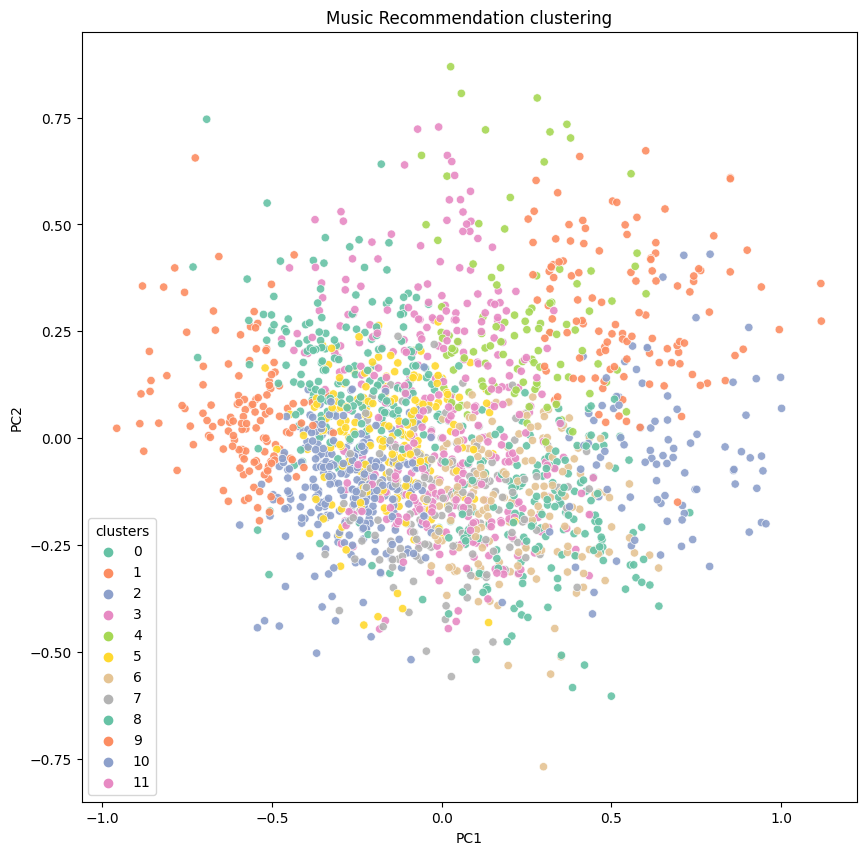

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_data,x='PC1',y='PC2',hue='clusters',palette='Set2' , alpha = 0.9)
plt.title('Music Recommendation clustering')

In [ ]:
r_song = song_df.loc[random.choice(song_df.index), :]
r_song

song_id                 SOEORDW12A6D4FB045
song_title                       Marrakech
duration                         262.21669
year                                  2004
danceability                           0.0
energy                                 0.0
loudness                              -6.4
tempo                              132.998
time_signature                           4
segment_loudness_avg            -16.831671
chroma1                           0.680277
chroma2                           0.734048
chroma3                            0.39337
chroma4                           0.381416
chroma5                           0.309242
chroma6                           0.454584
chroma7                           0.391268
chroma8                           0.318778
chroma9                             0.4388
chroma10                          0.342739
chroma11                          0.509812
chroma12                          0.488657
MFCC1                            46.762872
MFCC2      

In [ ]:
# Recs by cluster
song_df[song_df['clusters'] == r_song['clusters']].head(5).loc[:, 'song_title'].to_list()

['Never Again (Album Version)',
 'Thriller',
 'The Plot To Bomb The Panhandle (Album Version)',
 'Going Down',
 'Marrakech']

In [ ]:
chosen_song = song_df[song_df['song_title'].str.contains("Silent Night")].index[0]
chosen_song

4

In [ ]:
knn = NearestNeighbors().fit(data_scaled.values)

In [ ]:
neighbors = knn.kneighbors([data_scaled.loc[chosen_song, :]], n_neighbors=5)
song_df.loc[neighbors[1][0][1:], 'song_title'].to_list()

['Kun rakastaa',
 'The Same Old Innocence',
 'Only Lonely',
 'Zavelow House (Album Version)']

# Recommendations

## Manual Recommendations

In [ ]:
def recommend_songs(chosen_song:str, knn:NearestNeighbors, song_df:pd.DataFrame):
    chosen_df = song_df[song_df['song_title'].str.contains(chosen_song)]
    if len(chosen_df) == 0:
        print(f"{chosen_song} was not found in the dataset!")
        return None
    song_index = chosen_df.index[0]
    neighbors = knn.kneighbors([data_scaled.loc[song_index, :]], n_neighbors=5)
    return song_df.loc[neighbors[1][0][1:], 'song_title'].to_list()

In [ ]:
chosen_song = input("Choose a song: ")
recommendations = recommend_songs(chosen_song, knn, song_df)
if recommendations is not None:
    print(f"Recommendations for '{chosen_song}'")
    for rec in recommendations:
        print(rec)

Choose a song: Thriller
Recommendations for 'Thriller'
Down (LP Version)
It's Alright Bruv
A Void Of Lifeless Dreams
Another Lover


## Random Recommendations
Used for when you don't know any song included in the dataset, you can get a random song and its recommendations

In [ ]:
def random_recommended_songs(knn:NearestNeighbors, song_df:pd.DataFrame):
    random_song = song_df.sample()
    neighbors = knn.kneighbors([data_scaled.loc[random_song.index[0], :]], n_neighbors=5)
    return (random_song['song_title'].iloc[0], song_df.loc[neighbors[1][0][1:], 'song_title'].to_list())

In [ ]:
random_song, recommendations = random_recommended_songs(knn, song_df)
print(f"Recommendations for '{random_song}'")
for rec in recommendations:
    print(rec)

Recommendations for 'Sickness'
Human Being
Parallel Universe (Album Version)
Automatic
Make It Last
